In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/who-is-the-real-winner/sample_submission.csv
/kaggle/input/who-is-the-real-winner/train.csv
/kaggle/input/who-is-the-real-winner/test.csv


In [2]:
#Defining Functions to Engineer 4 additional features: Dr, Adv, SC, ST
def Dr_Column(value):
    if 'Dr.' in value:
        return True
    else:
        return False

def Adv_Column(value):
    if 'Adv.' in value:
        return True
    else:
        return False
def SC_Column(value):
    if '(SC)' in value:
        return True
    else:
        return False

def ST_Column(value):
    if '(ST)' in value:
        return True
    else:
        return False
    
#Functions converting Assets and Liabilities to purely numerical data
def Numerical(value):
    if 'Crore+' in value:
        return int(value.split()[0])*100000
    elif 'Lac+' in value:
        return int(value.split()[0])*1000
    elif 'Thou+' in value:
        return int(value.split()[0])*10
    elif 'Hund+' in value:
        return int(value.split()[0])*1
    else:
        return int(value)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB

train_data_path='/kaggle/input/who-is-the-real-winner/train.csv'
test_data_path='/kaggle/input/who-is-the-real-winner/test.csv'

# Read the dataset
train_data = pd.read_csv(train_data_path)
test_data= pd.read_csv(test_data_path)

In [4]:
#Data Analysis
train_data.head()

,ID,Candidate,Constituency ∇,Party,Criminal Case,Total Assets,Liabilities,state,Education
0,0,M.K. Mohan,ANNA NAGAR,DMK,4,211 Crore+,2 Crore+,TAMIL NADU,8th Pass
1,1,Khatik Ramesh Prasad,KARERA (SC),BJP,0,1 Crore+,0,MADHYA PRADESH,12th Pass
2,2,Dr. Mantar Gowda,MADIKERI,INC,0,7 Crore+,22 Lac+,KARNATAKA,Post Graduate
3,3,Kundan Kumar,BEGUSARAI,BJP,0,9 Crore+,24 Lac+,BIHAR,Post Graduate
4,4,Swapan Majumder,BANGAON DAKSHIN (SC),BJP,2,2 Crore+,61 Lac+,WEST BENGAL,8th Pass


In [5]:
train_data.isnull().sum()

ID                0
Candidate         0
Constituency ∇    0
Party             0
Criminal Case     0
Total Assets      0
Liabilities       0
state             0
Education         0
dtype: int64

Clearly, the train data does not have null values. We need not clean the data.

# **Columns Present**

In [6]:
print(train_data.describe())
print('***')
print(train_data.columns)

                ID  Criminal Case
count  2059.000000    2059.000000
mean   1029.000000       1.777562
std     594.526422       4.762183
min       0.000000       0.000000
25%     514.500000       0.000000
50%    1029.000000       0.000000
75%    1543.500000       2.000000
max    2058.000000      87.000000
***
Index(['ID', 'Candidate', 'Constituency ∇', 'Party', 'Criminal Case',
       'Total Assets', 'Liabilities', 'state', 'Education'],
      dtype='object')


# **Distribution of Parties**

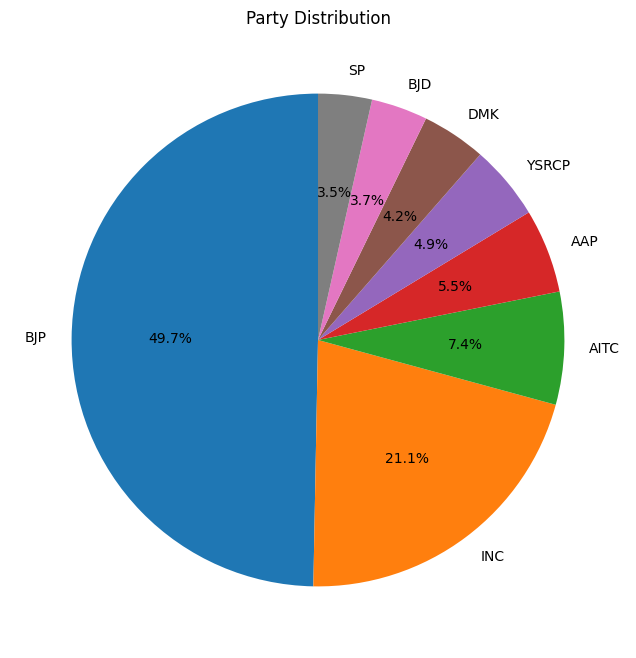

Party
BJP                         578
INC                         245
AITC                         86
AAP                          64
YSRCP                        57
DMK                          49
BJD                          43
SP                           41
CPI(M)                       29
IND                          26
RJD                          26
NCP                          23
AIADMK                       23
JD(U)                        19
SHS                          19
NPP                          13
JMM                           9
NDPP                          6
TDP                           6
JD(S)                         5
Sikkim Krantikari Morcha      3
Tipra Motha Party             2
CPI                           2
Name: count, dtype: int64


In [7]:
#Distribution of Parties
import matplotlib.pyplot as plt
party_counts=test_data['Party'].value_counts()
# Filter parties with count >= 1.5%
party_counts_filtered = party_counts[party_counts / len(train_data) >= 0.015]

# Plotting as a pie chart
plt.figure(figsize=(8, 8))
party_counts_filtered.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Party Distribution')
plt.ylabel('')
plt.show()

print(party_counts)


# **Criminal Cases per person by Party**

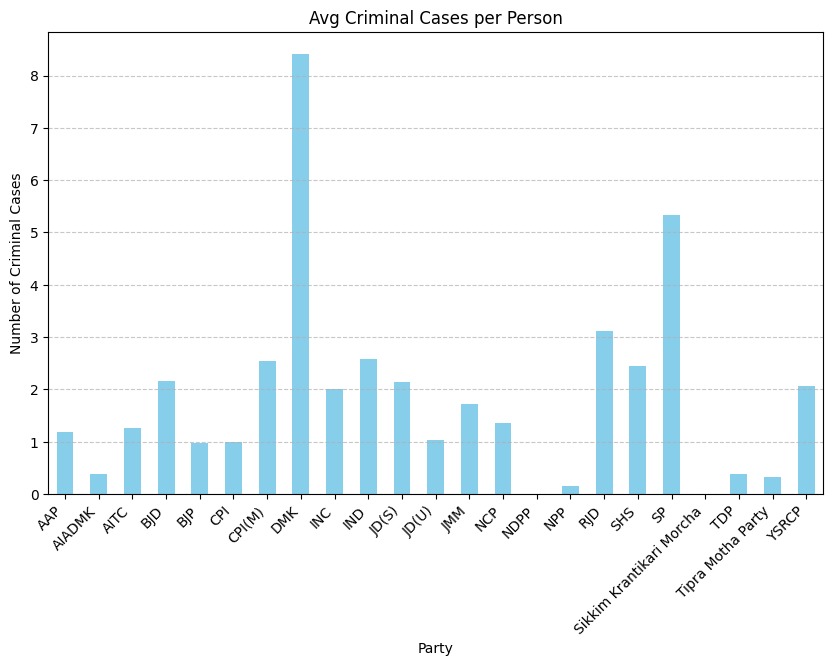

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

total_entries_per_party = train_data['Party'].value_counts()
# Assuming test_data is your DataFrame containing criminal cases and party information
criminal_cases_per_party = train_data.groupby('Party')['Criminal Case'].sum()

criminal_cases_per_person = (criminal_cases_per_party / total_entries_per_party)
# Filtering parties with criminal cases
criminal_cases_per_party = criminal_cases_per_party[criminal_cases_per_party > 0]

# Plotting as a bar plot
plt.figure(figsize=(10, 6))
criminal_cases_per_person.plot(kind='bar', color='skyblue')
plt.title('Avg Criminal Cases per Person')
plt.xlabel('Party')
plt.ylabel('Number of Criminal Cases')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**SP and DMK have many members with frequent criminal records**

In [9]:
train_data['Total Assets'] = train_data['Total Assets'].apply(Numerical)
test_data['Total Assets'] = test_data['Total Assets'].apply(Numerical)
train_data['Liabilities'] = train_data['Liabilities'].apply(Numerical)
test_data['Liabilities'] = test_data['Liabilities'].apply(Numerical)

# **Per Capita Wealth in each Party**

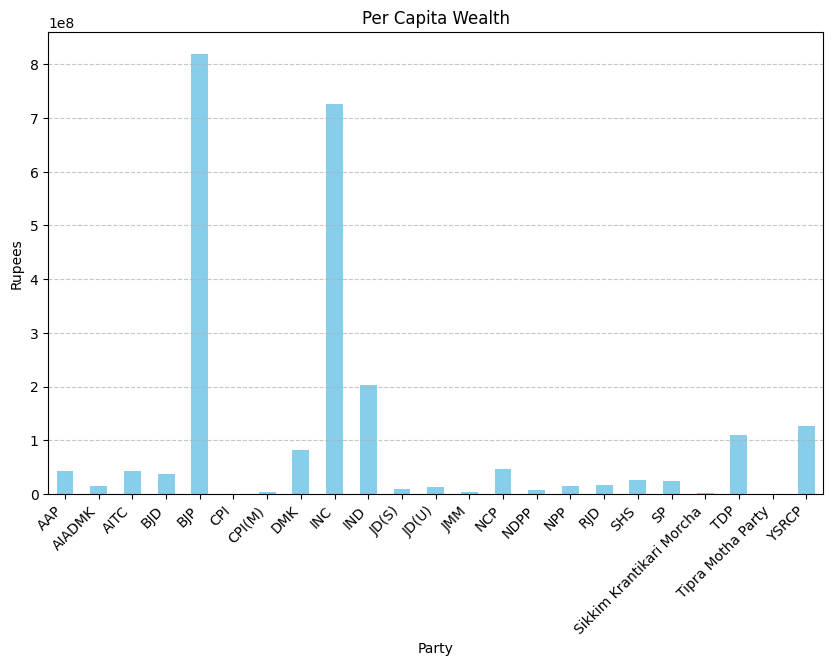

In [10]:
total_entries_per_party = train_data['Party'].value_counts()

assets_per_party = train_data.groupby('Party')['Total Assets'].sum()
liabilities_per_party = train_data.groupby('Party')['Liabilities'].sum()

wealth_per_person = (assets_per_party-liabilities_per_party / total_entries_per_party)


# Plotting as a bar plot
plt.figure(figsize=(10, 6))
wealth_per_person.plot(kind='bar', color='skyblue')
plt.title('Per Capita Wealth')
plt.xlabel('Party')
plt.ylabel('Rupees')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**BJP and INC have disproportionally large per capita wealth**

# **Education Level By Party**

<Figure size 1400x1000 with 0 Axes>

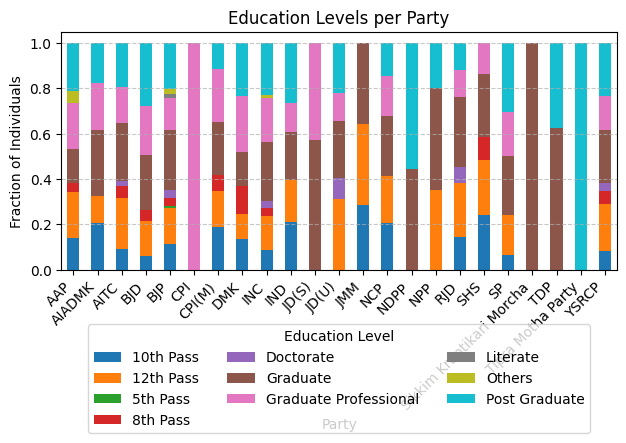

In [11]:
education_levels = ['Graduate', 'Graduate Professional', 'Post Graduate', '8th Pass', '10th Pass', '12th Pass', 'Others']

# Grouping by party and education level, and then counting the occurrences
education_counts_per_party = train_data.groupby(['Party', 'Education']).size().unstack(fill_value=0)

# Calculating total members per party
total_members_per_party = train_data['Party'].value_counts()

# Calculating fraction of members for each education level
education_fraction_per_party = education_counts_per_party.div(total_members_per_party, axis=0)

# Plotting as a grouped bar plot
plt.figure(figsize=(14, 10))  # Larger figure size
education_fraction_per_party.plot(kind='bar', stacked=True)
plt.title('Education Levels per Party')
plt.xlabel('Party')
plt.ylabel('Fraction of Individuals')
plt.xticks(rotation=45, ha='right')

# Placing legend below the bar graph
plt.legend(title='Education Level', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=3)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Interesting demographic within each party**

In [12]:
train_data['Dr'] = train_data['Candidate'].apply(Dr_Column)
train_data['Adv'] = train_data['Candidate'].apply(Adv_Column)
test_data['Dr'] = test_data['Candidate'].apply(Dr_Column)
test_data['Adv'] = test_data['Candidate'].apply(Adv_Column)

train_data['SC'] = train_data['Constituency ∇'].apply(SC_Column)
train_data['ST'] = train_data['Constituency ∇'].apply(ST_Column)
test_data['SC'] = test_data['Constituency ∇'].apply(SC_Column)
test_data['ST'] = test_data['Constituency ∇'].apply(ST_Column)



# Drop columns that are redundant 
train_data=train_data.drop(['Candidate','Constituency ∇'], axis=1)
test_data=test_data.drop(['Candidate','Constituency ∇'], axis=1)

#Candidate data has been consolidated in Dr, Adv features
#Constituency data has been consolidated in SC, ST features

In [13]:
#Attempts with RandomForestClassifier, KNN, DecisionTreeClassifier
# Convert categorical variables into numerical format
# label_encoder = LabelEncoder()
# # X['Party'] = label_encoder.fit_transform(X['Party'])
# # X['Candidate'] = label_encoder.fit_transform(X['Candidate'])

# # One-hot encode the 'Constituency ∇' column
# # constituency_encoded = pd.get_dummies(X['Constituency ∇'])
# # X = pd.concat([X, constituency_encoded], axis=1)
# # X = X.drop(['Constituency ∇'], axis=1)

# Party_encoded = pd.get_dummies(X['Party'])
# X = pd.concat([X, Party_encoded], axis=1)
# X = X.drop(['Party'], axis=1)

# state_encoded = pd.get_dummies(X['state'])
# X = pd.concat([X, state_encoded], axis=1)
# X = X.drop(['state'], axis=1)



# Convert 'Total Assets' and 'Liabilities' columns to numerical format
# X['Total Assets'] = X['Total Assets'].str.replace(' Crore+', 'e7').str.replace(' Lac+', 'e5').str.replace(' Thou+', 'e3').str.replace(' Hund+', 'e2').astype(float)
# X['Liabilities'] = X['Liabilities'].str.replace(' Crore+', 'e7').str.replace(' Lac+', 'e5').str.replace(' Thou+', 'e3').str.replace(' Hund+', 'e2').astype(float)

# Split the dataset into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y,  random_state=1)

# Initialize the KNN classifier

# max=0
# # for i in range(1,101):   
# knn = MultinomialNB(alpha=0.6)
    

#     # Train the classifier
# knn.fit(X_train, y_train)

#         # Predict on the validation set
# y_pred = knn.predict(X_val)

#         # Evaluate the model
# accuracy = f1_score(y_val, y_pred,average='weighted')
# #     if(accuracy>max):
# #         max=accuracy
# #         print(i)
# # print(max)


# print(accuracy)


In [14]:
# Preprocessing using KBinsDiscretizer
from sklearn.preprocessing import KBinsDiscretizer
# train_data = train_data.copy()
test_data = test_data.copy()

# Labelling using discretizer
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
train_data['Criminal Case'] = discretizer.fit_transform(train_data[['Criminal Case']])
train_data['Total Assets'] = discretizer.fit_transform(train_data[['Total Assets']])
train_data['Liabilities'] = discretizer.fit_transform(train_data[['Liabilities']])


train_data = pd.get_dummies(train_data, columns=['Party', 'state'])


X = train_data.drop(columns=['Education'])  
y = train_data['Education']  # Replace 'Your_Label_Column' with the column name of the target variable

test_data['Total Assets'] = discretizer.fit_transform(test_data[['Total Assets']])
test_data['Liabilities'] = discretizer.fit_transform(test_data[['Liabilities']])
test_data['Criminal Case'] = discretizer.fit_transform(test_data[['Criminal Case']])

# One-hot encode categorical columns (Party and State)
test_data = pd.get_dummies(test_data, columns=['Party', 'state'])

# Split data into features and labels
XTest = test_data  

In [15]:
#Checking cross validation scores for MultinomialNB
from sklearn.model_selection import KFold,cross_val_score
model = MultinomialNB(alpha = 0.06, fit_prior = True)       #tuned
train_X , val_X, train_y, val_y = train_test_split(X,y,random_state = 1)

#Taking 5 scores
kf1 = KFold(n_splits = 5, shuffle=True, random_state=48)

# Perform cross-validation
scores = cross_val_score(model, X, y, cv=kf1, scoring='accuracy')

# Calculate mean and standard deviation of accuracy scores
mean_accuracy = scores.mean()
std_accuracy = scores.std()
print(scores)
print(mean_accuracy)
print(std_accuracy)


[0.25970874 0.25728155 0.22087379 0.20873786 0.26520681]
0.2423617508799282
0.022968298556179916


In [16]:
# df = pd.DataFrame({'Education':y_pred})
# df["ID"] = df.index
# df.set_index("ID")
# df.to_csv('sample_submission1.csv',encoding = 'utf-8',index = False)

In [17]:
model.fit(X, y)

# Step 3: Model Evaluation
y_predicted = model.predict(XTest)
final_dataframe = pd.DataFrame(y_predicted, columns=["Education"])

final_dataframe.to_csv('Multi_NB.csv', index_label='ID')